<a href="https://colab.research.google.com/github/l3t022/Clase_Analitica/blob/main/colab/tarea_no_supervisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

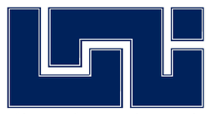

</center>

<h1><b>
Dirección de Estudios de Posgrado y Educación Continua
<h2><b>
Analítica Predictiva y Machine Learning con R, Python y Databricks

[UNI-DEPEC](https://posgrado.uni.edu.ni)

~~~Python
Torres Gutierrez, Leopoldo Jose
~~~

# **Tarea Modelo no Supervisado**

## **Objetivo**

Crear un modelo de agrupamiento (clustering) que pueda crear grupos de preferencias de compras de automoviles usados, para uso personal en las ciudades de USA, tratando de identificar las fronteras (variables) de cada grupo.

## **Conjunto de Datos**

Se utilizará el siguiente sub conjunto de datos de automóviles usados, depurada en la tarea anterior (modelo de regresion).

La lista muestra datos de vehículos en USA, cuya información es gestionada en la Web de Craigslist.org -

El conjunto de datos posee 13 variables:

- **price:** precio del automovil.
- **year:** año de fabricación.
- **manufacturer:** nombre del fabricante.
- **model:** modelo del auto.
- **cylinders:** cilindraje del auto.
- **odometer:** número de millas recorridas.
- **title_status:** grado o estatus de propiedad del bien.
- **transmission:** tipo de transmisión del automovil (automatica, mecanica, otro).
- **drive:** tipo de tracción del carro (trasera, delantera, etc.)
- **size:** tamaño del auto  (compacto, mediano, grande).
- **type:** tipo de automovil.
- **paint_color:** color del auto.
- **state:** nombre del Estado en USA.

## **Carga de módulos y Datos**

Carga de librerías necesarias

In [1]:
# Analisis de datos
import pandas as pd 
import numpy as np
import statsmodels.api as sm
from sklearn.datasets import make_blobs

# Preprocesado y modelado
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

# Librerias de gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Configuración warnings
import warnings
warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Carga de los datos que se utilizarán para crear el DataFrame

In [2]:
url = "https://raw.githubusercontent.com/l3t022/Clase_Analitica/main/csv/"

In [3]:
archivo = "vehicles2.csv"

In [4]:
datos = pd.read_csv(url+archivo)
datos.head()

,price,year,manufacturer,model,cylinders,odometer,title_status,transmission,drive,size,type,paint_color,state
0,19900,2004,ford,f250 super duty,8 cylinders,88000.0,clean,automatic,4wd,full-size,pickup,blue,al
1,14000,2012,honda,odyssey,6 cylinders,95000.0,clean,automatic,fwd,full-size,mini-van,silver,al
2,15000,2017,dodge,charger rt 4dr sedan,8 cylinders,90000.0,rebuilt,automatic,rwd,mid-size,sedan,grey,al
3,3000,2004,chrysler,town & country,6 cylinders,176144.0,clean,automatic,fwd,mid-size,mini-van,silver,al
4,9500,2003,chrysler,town & country,6 cylinders,30376.0,clean,automatic,fwd,mid-size,mini-van,blue,al


## **Limpieza de los Datos**

Revision de las variables y nulos

In [5]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55259 entries, 0 to 55258
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         55259 non-null  int64  
 1   year          55259 non-null  int64  
 2   manufacturer  55259 non-null  object 
 3   model         55259 non-null  object 
 4   cylinders     55259 non-null  object 
 5   odometer      55259 non-null  float64
 6   title_status  55259 non-null  object 
 7   transmission  55259 non-null  object 
 8   drive         55259 non-null  object 
 9   size          55259 non-null  object 
 10  type          55259 non-null  object 
 11  paint_color   55259 non-null  object 
 12  state         55259 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 5.5+ MB


In [6]:
datos.isna().sum().sort_values()

price           0
year            0
manufacturer    0
model           0
cylinders       0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

No hay valores nulos en varias variables. Y se seleccionaron las variables para el estudio

In [7]:
# Separacion de numeros y textos en "cylinders" y se combino el nuevo Data Frame con el original
cylinders = datos["cylinders"].str.split(expand=True)
cylinders.columns = ['n_cylinders', 'last_phrase']
datos = pd.concat([datos, cylinders], axis=1)
datos

,price,year,manufacturer,model,cylinders,odometer,title_status,transmission,drive,size,type,paint_color,state,n_cylinders,last_phrase
0,19900,2004,ford,f250 super duty,8 cylinders,88000.0,clean,automatic,4wd,full-size,pickup,blue,al,8,cylinders
1,14000,2012,honda,odyssey,6 cylinders,95000.0,clean,automatic,fwd,full-size,mini-van,silver,al,6,cylinders
2,15000,2017,dodge,charger rt 4dr sedan,8 cylinders,90000.0,rebuilt,automatic,rwd,mid-size,sedan,grey,al,8,cylinders
3,3000,2004,chrysler,town & country,6 cylinders,176144.0,clean,automatic,fwd,mid-size,mini-van,silver,al,6,cylinders
4,9500,2003,chrysler,town & country,6 cylinders,30376.0,clean,automatic,fwd,mid-size,mini-van,blue,al,6,cylinders
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55254,9995,2015,chevrolet,impala limited,6 cylinders,91039.0,clean,automatic,fwd,mid-size,sedan,grey,wy,6,cylinders
55255,10999,2015,chevrolet,"malibu, ls",4 cylinders,96823.0,clean,automatic,fwd,mid-size,sedan,silver,wy,4,cylinders
55256,24995,2014,jeep,grand cherokee,8 cylinders,95704.0,clean,automatic,4wd,full-size,SUV,white,wy,8,cylinders
55257,12995,2016,chevrolet,cruze lt,4 cylinders,61127.0,clean,automatic,fwd,compact,sedan,silver,wy,4,cylinders


Se tomo la decision de limitar la base de datos a un fabricante (Ford) y que la propiedad no tuviera ningun inconveniente (clean).

In [8]:
datos=datos[(datos.manufacturer == 'ford')] # Reduccion al fabricante Ford
datos.shape

(8514, 15)

In [9]:
datos=datos[(datos.title_status == 'clean')] # Reduccion a vehiculos sin problemas de propiedad
datos.shape

(8054, 15)

In [10]:
datos1 = datos

 Y se eliminaron las variables innecesarias: "manufacturer", "model", "cylinders", "title_status", "transmission", "drive", "type", "paint_color", "state", "last_phrase"

In [11]:
datos = datos.drop(columns=["manufacturer", "model", "cylinders", "title_status", "transmission", "drive", "type", "paint_color", "state", "last_phrase"])
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8054 entries, 0 to 55251
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        8054 non-null   int64  
 1   year         8054 non-null   int64  
 2   odometer     8054 non-null   float64
 3   size         8054 non-null   object 
 4   n_cylinders  8054 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 377.5+ KB


In [12]:
datos['n_cylinders'] = datos['n_cylinders'].astype(int) #convertir de float64 a int64
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8054 entries, 0 to 55251
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        8054 non-null   int64  
 1   year         8054 non-null   int64  
 2   odometer     8054 non-null   float64
 3   size         8054 non-null   object 
 4   n_cylinders  8054 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 377.5+ KB


## **Análisis Exploratorio de los Datos  (EDA)**

Revision de las variables numéricas y categoricas

In [13]:
datos.select_dtypes(include=['float64', 'int']).describe() #variables numericas

,price,year,odometer,n_cylinders
count,8054.000000,8054.000000,8054.000000,8054.000000
mean,11010.897442,2010.437174,126270.867892,5.976161
std,6913.770090,4.519749,53284.791843,1.602317
min,995.000000,2001.000000,1000.000000,4.000000
25%,5500.000000,2007.000000,90450.000000,4.000000
50%,9000.000000,2011.000000,124062.500000,6.000000
75%,15000.000000,2014.000000,160264.000000,8.000000
max,29999.000000,2019.000000,299500.000000,8.000000


In [14]:
datos.select_dtypes(include=['object']).describe() #variable categorica

,size
count,8054
unique,4
top,full-size
freq,4804


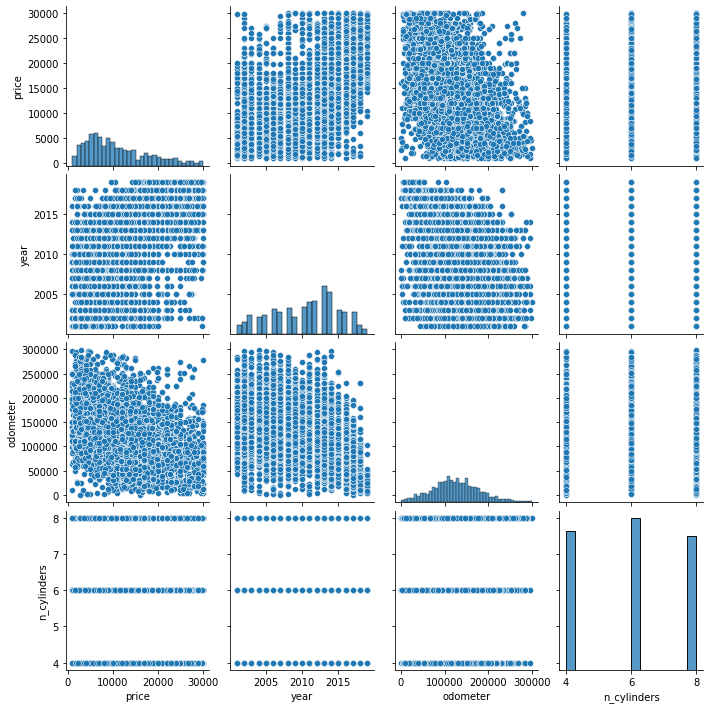

In [15]:
sns.pairplot(datos)

In [16]:
categoria = datos.columns
numerico = ['price', 'year', 'odometer', 'n_cylinders']
categorical = datos.drop(numerico, axis=1)
numerical = datos[numerico]
categorical.head()

,size
0,full-size
9,compact
34,full-size
38,full-size
41,mid-size


In [17]:
fig = px.scatter(numerical,'price','odometer',
                 template = "gridon")
fig.show()

## **Codificacion**

In [18]:
import sklearn 
from sklearn.preprocessing import LabelEncoder

In [19]:
# Se asigno a un objeto la funcion LabelEncoder
convertir = LabelEncoder()

In [20]:
categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8054 entries, 0 to 55251
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   size    8054 non-null   object
dtypes: object(1)
memory usage: 445.8+ KB


In [21]:
# Se convirtio a string las columna para luego poder aplicar LabelEncoder( )
datos['size'] = datos['size'].apply(str)           # AttributeError: 'numpy.int64' object has no attribute 'apply' (size es una propiedad!)

In [22]:
# Se procedio a la conversion
datos.insert(4,column="numsize",value=convertir.fit_transform(datos['size']))

In [23]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8054 entries, 0 to 55251
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        8054 non-null   int64  
 1   year         8054 non-null   int64  
 2   odometer     8054 non-null   float64
 3   size         8054 non-null   object 
 4   numsize      8054 non-null   int64  
 5   n_cylinders  8054 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 760.5+ KB


In [24]:
X = datos.drop(['size'], axis = 1)
X.head()

,price,year,odometer,numsize,n_cylinders
0,19900,2004,88000.0,1,8
9,21250,2002,15996.0,0,8
34,24888,2019,8176.0,1,6
38,11500,2008,283356.0,1,8
41,6900,2008,103550.0,2,4


## **Mapas de Calor (correlacion)**

Previo a definir el modelo de agrupacion, se quizo conocer la correlacion de las diferentes variables en el datafame 'X'.

In [25]:
datoscorrelacion = X.corr()

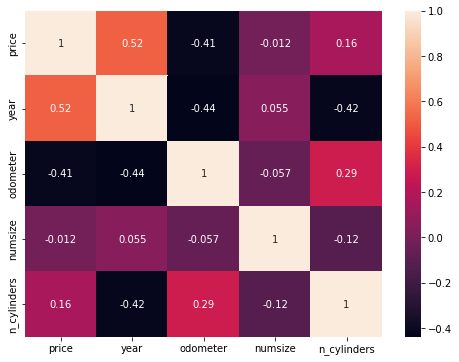

In [40]:
# Grafico de Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(datoscorrelacion, annot=True)

plt.show()

Aca se visualiza que las variables correlacionadas, positivamente ('year', 'price') y negativamente ('odometer' con 'price' y 'year', y 'n_cylinders' con 'year') 

## **Clustering**



Primero se determino el numero optimo de cluster utilizando el Metodo del Codo y posteriormente se creo el modelo aplicando k-means

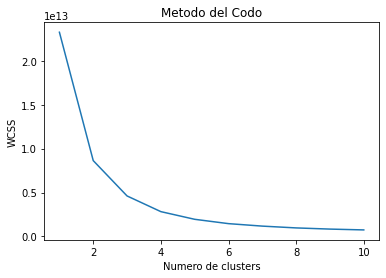

In [27]:
# Usando el Metodo del Codo para encontrar el numero optimo de clusters
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Metodo del Codo')
plt.xlabel('Numero de clusters')
plt.ylabel('WCSS')
plt.show()

Se determino que el numero de cluster era 3.

In [28]:
# Aplicando k-means al conjunto de datos y entrenando el modelo
kmeans = KMeans(n_clusters=3,init='k-means++',max_iter=300,n_init=10,random_state=42) 
kmeans.fit(X)

KMeans(n_clusters=3, random_state=42)

In [29]:
# Predicción
y_kmeans = kmeans.fit_predict(X)
y_kmeans

array([0, 0, 0, ..., 1, 2, 2], dtype=int32)

In [30]:
# Se adjunto la predicción al dataframe
X['cluster'] = y_kmeans
#X.info()

A continuacion se graficaran los cluster

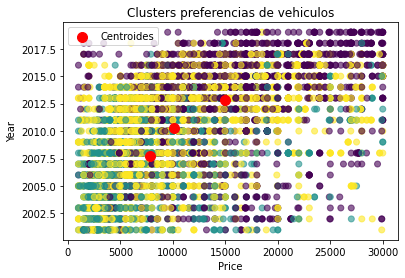

In [31]:
# Visualizando los clusters, price vs year
#plt.scatter(X.price, X.year, c=X.cluster, s=X.n_cylinders, alpha = 0.6)
plt.scatter(X.price, X.year, c=X.cluster, alpha = 0.6)
plt.title('Clusters preferencias de vehiculos')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=100,c='red',label='Centroides')
plt.xlabel('Price')
plt.ylabel('Year')
plt.title('Clusters preferencias de vehiculos')
plt.legend()
plt.show()

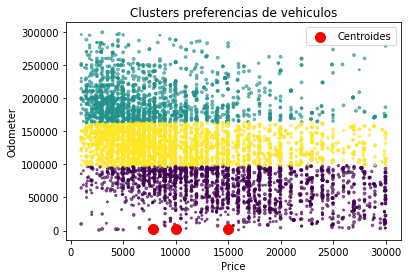

In [32]:
# Visualizando los clusters, price vs odometer
plt.scatter(X.price, X.odometer, c=X.cluster, s=X.n_cylinders, alpha = 0.6)
plt.title('Clusters preferencias de vehiculos')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=100,c='red',label='Centroides')
plt.xlabel('Price')
plt.ylabel('Odometer')
plt.title('Clusters preferencias de vehiculos')
plt.legend()
plt.show()

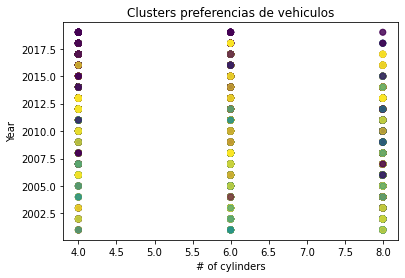

In [33]:
# Visualizando los clusters, n_cylinders vs year 
plt.scatter(X.n_cylinders, X.year, c=X.cluster, alpha = 0.6)
plt.title('Clusters preferencias de vehiculos')
plt.xlabel('# of cylinders')
plt.ylabel('Year')
plt.show()

In [34]:
# Visualizando los clusters, usando plotly 2D
fig = px.scatter(X, x='price', y='year', color ='cluster')
fig.show()


In [35]:
# Visualizando los clusters, usando plotly 2D
fig = px.scatter(X, x='price', y='odometer', color ='cluster')
fig.show()

In [36]:
# Visualizando los clusters, usando plotly 2D
fig = px.scatter(X, x='n_cylinders', y='odometer', color ='cluster')
fig.show()

Aca se pudo observar que la definicion del cluster esta asociado fuertemente a la variable *'odometer'*, cuyas fronteras aprox. estan a los 100k y 160k millas.

In [37]:
# Visualizando los clusters, usando plotly 3D
#fig = px.scatter_3d(X, x="price", y="year", z="odometer", color='cluster', size='n_cylinders', symbol='numsize')
fig = px.scatter_3d(X, x="price", y="year", z="odometer", color='cluster', size='n_cylinders')
fig.show()

In [38]:
X.cluster.value_counts()

2    3760
0    2401
1    1893
Name: cluster, dtype: int64

In [39]:
kmeans.cluster_centers_

array([[1.49944481e+04, 2.01279408e+03, 6.57795465e+04, 1.27261359e+00,
        5.46894539e+00],
       [7.83916675e+03, 2.00774565e+03, 1.98090541e+05, 1.18364116e+00,
        6.64907652e+00],
       [1.00677835e+04, 2.01028989e+03, 1.28669910e+05, 1.22473404e+00,
        5.96063830e+00]])

# **Conclusiones**


1. Para realizar la agrupacion, se limito el analisis solo a un fabricante (Ford) y que la propiedad no tuviera ningun inconveniente para su venta (clean).
2. Se observo que la definicion de las fronteras del cluster de nuestro modelo (k-means), esta asociado fuertemente a la variable *'odometer'*. Las fronteras aprox. estan a los 100k y 160k millas.
3. El cluster 2 presenta una mayor concentracion de los datos, y una mayor cantidad (3,760 que representa un 46.7%). 
4. Al resultar una simplificacion, esta pendiente analizar como afecta las preferencias de compra en cada uno de los estados en USA.